<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Machine Learning Pipelines</span></div>

<div class="alert alert-danger alert-info">
     In this notebook you will learn how to automate your machine learning model pipelines. Specifically, the topics covered are as follows:<br>
    <ol>
        <li>Auto-ML</li>
        <li>Grid-search CV/Randomized Search CV</li>
        <li>Example project</li>
    </ol>
</div>

In [8]:
# General Libraries
import re
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV,
                                    StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                            GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score)

# XGBoost
import xgboost as xgb

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                    EditedNearestNeighbours, 
                                    RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap

In [9]:
df = pd.read_csv('transactions_clean_onehot.csv')
df.head()

,Unnamed: 0,is_fraud,diff_datetime_hrs,prev_fraud,amt,city_pop,age,dist_to_merch_in_kms,category_entertainment,category_food_dining,...,city_San Pedro,city_Santa Rosa,city_Sorsogon,city_Surigao,city_Tacloban,city_Taguig City,city_Tagum,city_Tandag,city_Tarlac City,city_Valenzuela
0,0,0,NaN,0.0,115.58,574089,83,66.720087,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,7.0,0.0,4.35,574089,83,89.750504,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0.0,0.0,4.65,574089,83,31.625560,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,13.0,0.0,32.87,574089,83,112.130879,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1.0,0.0,192.43,574089,83,101.931179,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df['diff_datetime_hrs'] = df['diff_datetime_hrs'].fillna(0)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
display(df.head(), len(df))

,is_fraud,diff_datetime_hrs,prev_fraud,amt,city_pop,age,dist_to_merch_in_kms,category_entertainment,category_food_dining,category_gas_transport,...,city_San Pedro,city_Santa Rosa,city_Sorsogon,city_Surigao,city_Tacloban,city_Taguig City,city_Tagum,city_Tandag,city_Tarlac City,city_Valenzuela
0,0,0.0,0.0,115.58,574089,83,66.720087,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,7.0,0.0,4.35,574089,83,89.750504,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,0.0,4.65,574089,83,31.625560,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,13.0,0.0,32.87,574089,83,112.130879,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,0.0,192.43,574089,83,101.931179,0,0,0,...,0,0,0,0,0,0,0,0,0,0


89650

Would Recommend:       0
0  89155
1    495
Proportion Chance Criterion: 98.90%
1.25 * Proportion Chance Criterion: 123.63%


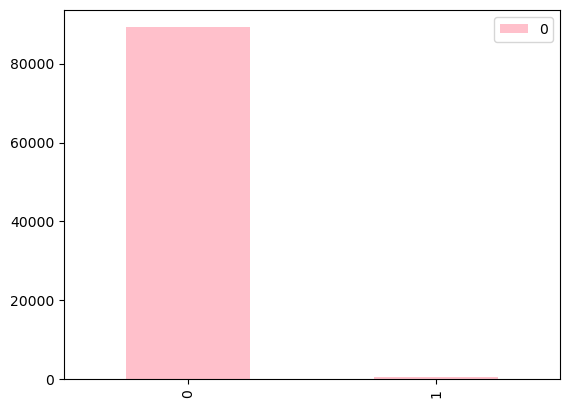

In [11]:
state_counts = Counter(df['is_fraud'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [12]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                random_state=11, test_size=0.25,
                                                                stratify=y)

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Auto-ML </span></div>

In [13]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

### Baseline

In [14]:
# models_dict = {'GaussianNB': GaussianNB(),
#             'RandomForestClassifier': RandomForestClassifier(random_state=143)}

models_dict = {'XGBoost': xgb.XGBClassifier()}

# models_dict = {
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'LogisticRegressor': LogisticRegression(),
#     'GaussianNB': GaussianNB(),
#     'RandomForestClassifier': RandomForestClassifier(random_state=143),
#     'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
#     'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)   
# }

In [16]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[10:42:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Applying resampling techniques

#### Oversampling

In [ ]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

In [ ]:
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Undersampling

In [ ]:
res_list = [
            # ,
            ('NearMiss', NearMiss()),
            ('TomekLinks', TomekLinks())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

In [ ]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']

fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Grid-Search and Randomized Search Cross Validation </span></div>

[Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Randomized Search Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) are commonly used to hypertune models across multiple parameters

In [ ]:
def train_rf(X, y, metric, res_t=None, hypertune=False, resample=False):
    """Hypertune Random Forest and apply TomekLinks()"""
    params = {'n_estimators': [50, 100, 150, 200],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': list(range(3, 20))
            }
    new_params = {'randomforestclassifier__' +
                key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                    res_t,
                                    RandomForestClassifier(random_state=143))
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                    RandomForestClassifier(random_state=143))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                        cv=skf, scoring=metric, return_train_score=True,
                        verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Random Forest Classifier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                scoring=metric, cv=skf, n_jobs=-1,
                                return_train_score=True)

        return ['Random Forest Classifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [ ]:
start_time = time.time()
rf_tmk_rec = train_rf(X_trainval, y_trainval, 'recall', TomekLinks(),
                    hypertune=True, resample=True)
start_time = time.time()
rf_tmk_acc = train_rf(X_trainval, y_trainval, 'accuracy', TomekLinks(),
                    hypertune=True, resample=True)

In [ ]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [rf_tmk_rec[0],
                np.round(rf_tmk_acc[1]*100, 6),
                np.round(rf_tmk_acc[2]*100, 6),
                np.round(rf_tmk_rec[1]*100, 6),
                np.round(rf_tmk_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [rf_tmk_rec[0],
                '{:.2f}%'.format(np.round(rf_tmk_acc[1]*100, 2)),
                '{:.2f}%'.format(np.round(rf_tmk_acc[2]*100, 2)),
                '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2))]
hyper2.style.hide_index()

In [ ]:
# re-fitting for the holdout
rh = rf_tmk_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

#### Base-case

In [ ]:
# cross-validation
base_var = train_rf(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [ ]:
holdout_score

In [ ]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2)),
                '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Grid-Search and Randomized Search Cross Validation of XGBoost</span></div>

In [15]:
def train_xgb(X, y, metric, res_t=None, hypertune=False, resample=False):
    """Hypertune XGBoost and apply Adasyn"""
    # params = {
    #     'max_depth': [3, 5, 10],
    #     'learning_rate': [0.05],
    #     'gamma': [1, 5, 10],
    #     'reg_alpha' : [40, 60, 80, 100],
    #     'reg_lambda' : [0, 0.5, 1],
    #     'colsample_bytree' : [0.5, 1],
    #     'min_child_weight' : [10],
    #     'n_estimators': [10],
    #     'seed': [42]
    # }
    
    params = {
        'max_depth': [3, 5],
        'learning_rate': [0.05],
        'gamma': [1],
        'reg_alpha' : [50],
        'reg_lambda' : [1],
        'colsample_bytree' : [0.5, 1],
        'min_child_weight' : [10],
        'n_estimators': [10],
        'seed': [42]
    }
    
    new_params = {'xgbclassifier__' +
                key: params[key] for key in params}
    # display(new_params)

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                    res_t,
                                    xgb.XGBClassifier())
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                    xgb.XGBClassifier())

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                        cv=skf, scoring=metric, return_train_score=True,
                        verbose=10, n_jobs=5)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['XGBoost Classifier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                scoring=metric, cv=skf, n_jobs=-1,
                                return_train_score=True)

        return ['XGBoostClassifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [ ]:
## Base Case

# cross-validation
base_var = train_xgb(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)
holdout_score

[20:17:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9758064516129032

In [ ]:
start_time = time.time()
xgb_tmk_rec = train_xgb(X_trainval, y_trainval, 'recall', ADASYN(), hypertune=False, resample=False)
start_time = time.time()
xgb_tmk_acc = train_xgb(X_trainval, y_trainval, 'accuracy', ADASYN(), hypertune=False, resample=False)

[20:19:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [xgb_tmk_rec[0],
                np.round(xgb_tmk_acc[1]*100, 6),
                np.round(xgb_tmk_acc[2]*100, 6),
                np.round(xgb_tmk_rec[1]*100, 6),
                np.round(xgb_tmk_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [xgb_tmk_rec[0],
                '{:.2f}%'.format(np.round(xgb_tmk_acc[1]*100, 2)),
                '{:.2f}%'.format(np.round(xgb_tmk_acc[2]*100, 2)),
                '{:.2f}%'.format(np.round(xgb_tmk_rec[1]*100, 2)),
                '{:.2f}%'.format(np.round(xgb_tmk_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
XGBoostClassifier,100.00%,99.97%,100.00%,97.30%


In [ ]:
# re-fitting for the holdout
xgbh = xgb_tmk_rec[-1]
xgbh.fit(X_trainval, y_trainval)
y_preds = xgbh.predict(X_holdout)
xgb_holdout_score = recall_score(y_holdout, y_preds)
xgb_holdout_score

[20:23:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9758064516129032

In [16]:
start_time = time.time()
xgb_tmk_rec = train_xgb(X_trainval, y_trainval, 'recall', ADASYN(), hypertune=True, resample=True)
start_time = time.time()
xgb_tmk_acc = train_xgb(X_trainval, y_trainval, 'accuracy', ADASYN(), hypertune=True, resample=True)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:  3.0min remaining:  1.3min
[Parallel(n_jobs=5)]: Done  17 out of  20 | elapsed:  3.7min remaining:   38.8s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  3.9min finished


[10:55:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:  2.8min remaining:  1.2min
[Parallel(n_jobs=5)]: Done  17 out of  20 | elapsed:  3.5min remaining:   36.6s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  3.7min finished


[11:00:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:00:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [xgb_tmk_rec[0],
                np.round(xgb_tmk_acc[1]*100, 6),
                np.round(xgb_tmk_acc[2]*100, 6),
                np.round(xgb_tmk_rec[1]*100, 6),
                np.round(xgb_tmk_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [xgb_tmk_rec[0],
                '{:.2f}%'.format(np.round(xgb_tmk_acc[1]*100, 2)),
                '{:.2f}%'.format(np.round(xgb_tmk_acc[2]*100, 2)),
                '{:.2f}%'.format(np.round(xgb_tmk_rec[1]*100, 2)),
                '{:.2f}%'.format(np.round(xgb_tmk_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
XGBoost Classifier,99.51%,99.88%,95.43%,98.92%


In [24]:
# re-fitting for the holdout
xgbh = xgb_tmk_rec[-1]
model = xgbh.fit(X_trainval, y_trainval)
y_preds = model.predict(X_holdout)
xgb_holdout_score = recall_score(y_holdout, y_preds)
xgb_holdout_score

[11:15:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9838709677419355

In [30]:
xgbh[2]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=50, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [25]:
xgb_tmk_rec[3]

"Best parameters = {'xgbclassifier__colsample_bytree': 1, 'xgbclassifier__gamma': 1, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 10, 'xgbclassifier__n_estimators': 10, 'xgbclassifier__reg_alpha': 50, 'xgbclassifier__reg_lambda': 1, 'xgbclassifier__seed': 42}"

In [34]:
explainer = shap.TreeExplainer(xgbh[2], feature_names=X_holdout.columns)
shap_values = explainer.shap_values(X_holdout)

ValueError: feature_names must be string, and may not contain [, ] or <

In [32]:
container

Index(['diff_datetime_hrs', 'prev_fraud', 'amt', 'city_pop', 'age',
       'dist_to_merch_in_kms', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_pos',
       ...
       'city_San Pedro', 'city_Santa Rosa', 'city_Sorsogon', 'city_Surigao',
       'city_Tacloban', 'city_Taguig City', 'city_Tagum', 'city_Tandag',
       'city_Tarlac City', 'city_Valenzuela'],
      dtype='object', length=253)